In [180]:
from platform import python_version
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
from sklearn.cluster import DBSCAN
from sklearn.hdb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [5]:
print(python_version())

3.7.3


In [7]:
pixels,target = tqdm(fetch_openml(
                            name= 'mnist_784',
                            return_X_y= True,
                            version = 'active'
))

100%|████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


In [8]:
print('pixels',pixels)
print('target',target)

pixels [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
target ['5' '0' '4' ... '4' '5' '6']


In [177]:
sample_size = 3000
tsne = TSNE(n_components=2, random_state= 42)
transformed_data = tsne.fit_transform(pixels[:sample_size])

tsne_df = pd.DataFrame(
                    np.column_stack((transformed_data,target[:sample_size])),
                    columns = ['x','y','target'],
)
tsne_df.target.astype('int')
tsne_df.head()

,x,y,target
0,-5.28155,-28.9528,5
1,-26.1059,-68.0693,0
2,-42.5036,35.5804,4
3,38.894,26.6634,1
4,-14.7706,35.4332,9


In [178]:
X = tsne_df.drop('target', axis =1)
X.shape

(3000, 2)

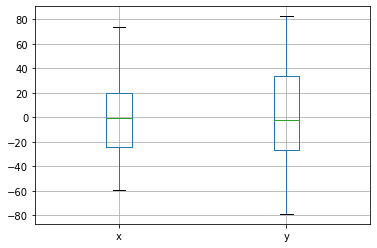

In [179]:
tsne_df.drop("target",axis =1).plot(kind = 'box',grid = True )

As we see from above that the values are almost in similar ranges, it won't matter that much in this case even if we don't scale the data. But I'll scale the data to be safe

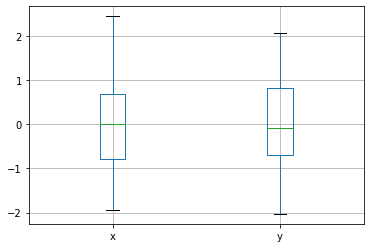

In [181]:
sc = StandardScaler()
transformed = sc.fit_transform(tsne_df.drop("target",axis = 1))
tsne_df = pd.DataFrame(
                    np.column_stack((transformed,target[:sample_size])),
                    columns = ['x','y','target'],
)
tsne_df.drop("target",axis =1).plot(kind = 'box',grid = True )

In [239]:
X = tsne_df.loc[:,['x','y']]
X.head()

,x,y
0,-0.149724,-0.760412
1,-0.835642,-1.75322
2,-1.37575,0.877496
3,1.30534,0.651175
4,-0.462276,0.873761


#### DBSCAN 

In [183]:
params = {
    'eps' :[0.2,0.3,0.4,0.5,0.6],
    'min_samples' :[3,4,5,6,7,9,10,11,13,15],
    'algorithms' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}

results = []
estimators = []

for ep in tqdm(params['eps']):
    for samples in params['min_samples']:
        for algo in params['algorithms']:
            
            dbscn = DBSCAN(eps = ep, min_samples = samples, algorithm= algo)
            dbscn.fit(X)
            
            if len(np.unique(dbscn.labels_)) > 1:
                
                score = metrics.silhouette_score(X,dbscn.fit_predict(X), metric = 'euclidean')
                
                results.append(score)
                estimators.append(dbscn)
            else:
                continue

results_df = pd.DataFrame(np.column_stack((results,estimators)),
            columns= ["Silhouette score", "Estimator"]
            ).sort_values(by="Silhouette score", ascending=False).head()
print(results_df)
print(results_df.iloc[:1,1])

100%|████████████████████████████████████████████| 5/5 [00:23<00:00,  4.62s/it]

   Silhouette score                                          Estimator
23        -0.319911  DBSCAN(algorithm='brute', eps=0.6, leaf_size=3...
22        -0.319911  DBSCAN(algorithm='kd_tree', eps=0.6, leaf_size...
21        -0.319911  DBSCAN(algorithm='ball_tree', eps=0.6, leaf_si...
20        -0.319911  DBSCAN(algorithm='auto', eps=0.6, leaf_size=30...
1         -0.408585  DBSCAN(algorithm='ball_tree', eps=0.2, leaf_si...
23    DBSCAN(algorithm='brute', eps=0.6, leaf_size=3...
Name: Estimator, dtype: object


In [184]:
dbscn = results_df.iloc[:1,1].values[0]
predicted_labels = dbscn.fit_predict(X)
cluster_df = pd.DataFrame(
                        np.column_stack((X,predicted_labels)),
                        columns = ['x','y','predicted targets']
)
cluster_df.head()

,x,y,predicted targets
0,-5.28155,-28.9528,-1
1,-26.1059,-68.0693,-1
2,-42.5036,35.5804,-1
3,38.894,26.6634,-1
4,-14.7706,35.4332,-1


In [185]:
cluster_df["predicted targets"].unique()

array([-1, 0, 1, 2], dtype=object)

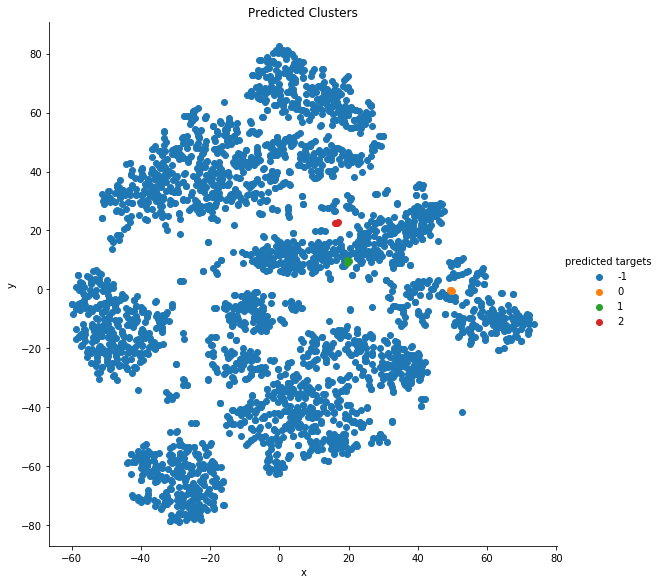

In [186]:
sns.FacetGrid(data = cluster_df, hue = 'predicted targets', height = 8).map(plt.scatter, 'x','y') \
.set(title = "Predicted Clusters").add_legend()

As we see with this approach we didn't get any satisfactory result close to our ground truth. So let us try once again to choose the values of the 2 main parameters epsilon and min_samples using another method.

Lets's find out the value for epsilon, which will be determined using K-distance graph.

We need the distance of a point in the datasets from its neighbours for all the points in the dataset. For that we'll use sklearn's NearestNeighbours

#### Finding optimal parameters with K-Distance graph

In [223]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2) #as we are taking into consideration 2 points
nbrs = neigh.fit(tsne_df)
distances, indices = nbrs.kneighbors(tsne_df)

In [225]:
distances

array([[0.        , 0.03071913],
       [0.        , 0.01430372],
       [0.        , 0.05160283],
       ...,
       [0.        , 0.01454084],
       [0.        , 0.02314043],
       [0.        , 0.02066842]])

The distance variable contains an array of distances between a data point and its nearest data point for all data points in the dataset.

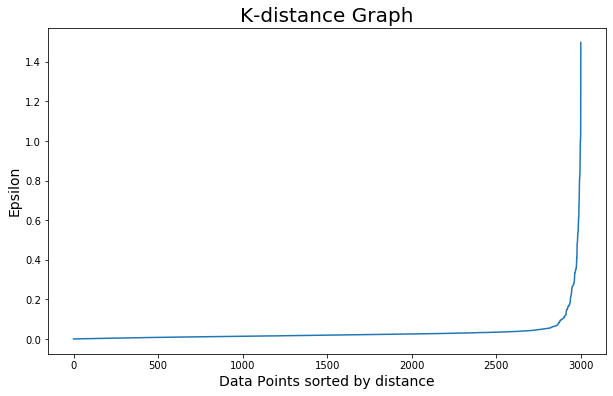

In [215]:
distances = np.sort(distances, axis=0) # first we'll sort the values in order
distances = distances[:,1]
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

The optimum value of epsilon in where the curvature is maximum. Here we'll take 0.1.

Now it's time to find out the optimum value for min_samples. The value of minPoints also depends on domain knowledge. But let us try with a list of values. This time we'll only focus on trying with min_samples as algorithm parameter didn't have much effect on the silhouette_score as we saw earlier.

A rule of thumb is min_samples >= (no. of dimensions + 1)

In [240]:
params = {
            'min_samples' : [3,5,7,9,10,11,14,15]
}
for samples in tqdm(params['min_samples']):

        dbscn = DBSCAN(eps = 0.1, min_samples = samples)
        dbscn.fit(X)

        if len(np.unique(dbscn.labels_)) > 1:

            score = metrics.silhouette_score(X,dbscn.fit_predict(X), metric = 'euclidean')

            results.append(score)
            estimators.append(dbscn)
        else:
            continue

results_df = pd.DataFrame(np.column_stack((results,estimators)),
            columns= ["Silhouette score", "Estimator"]
            ).sort_values(by="Silhouette score", ascending=False).head()
print(results_df)
print(results_df.iloc[:1,1])

100%|████████████████████████████████████████████| 8/8 [00:07<00:00,  1.13it/s]

   Silhouette score                                          Estimator
27         0.127392  DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...
28         0.124124  DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...
31         0.116088  DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...
26         0.107933  DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...
29        0.0949095  DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...
27    DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...
Name: Estimator, dtype: object


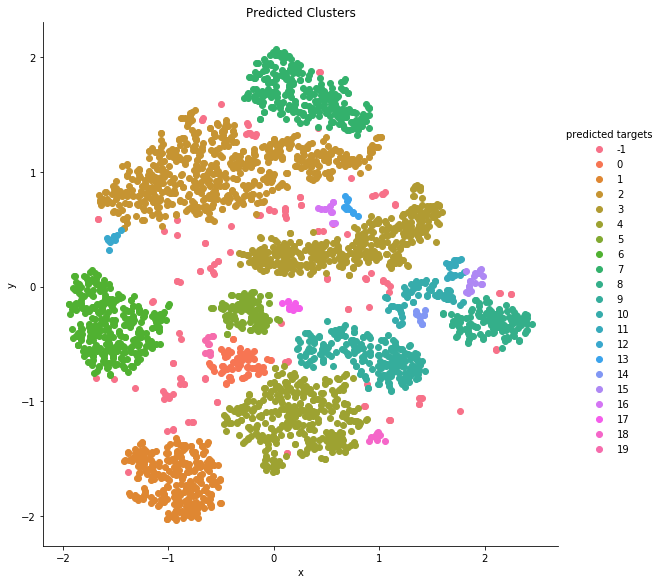

In [244]:
dbscn = results_df.iloc[:1,1].values[0]
predicted_labels = dbscn.fit_predict(X)
cluster_df = pd.DataFrame(
                        np.column_stack((X,predicted_labels)),
                        columns = ['x','y','predicted targets']
)
cluster_df.head()

sns.FacetGrid(data = cluster_df, hue = 'predicted targets', height = 8).map(plt.scatter, 'x','y') \
.set(title = "Predicted Clusters").add_legend()

We can see some better results following this approach, though it's far from the ground truth (i.e. 10 clusters) but at least the Silhouette score looks better than the previous and is on the positve value. 

Silhouette score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. So, here we are having close to overlapping clusters. The **score is higher** when clusters are **dense** and **well separated**, which relates to a standard concept of a cluster.

One thing important to note here is that, though DBSCAN creates clusters based on varying densities, it struggles with clusters of similar densities. Also, as the dimension of data increases, it becomes difficult for DBSCAN to create clusters and it falls prey to the Curse of Dimensionality.

references :

[analyticsvidya](https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/)

[sklearn](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

!pip install hdbscan